# Modelo de Puntuación Crediticia

## Primer Proyecto


<div style="display: flex; justify-content: space-between; align-items: center;">
  <div>
   <p>
  Por:

    Francisco Alexander Sotomayor Pineda.
    José Pablo Jiménez Mendoza.
    Paulo Adrián Villa Domínguez.

  Maestro:

    Rodolfo Slay Ramos
   </p>
  </div>
  <div>
    <img src="https://i0.wp.com/cimtrajalisco.org/wp-content/uploads/2019/02/Logo_Horizontal-1024x472.jpg?fit=1024%2C472" alt="ITESO" width="550"/>
  </div>
</div>


In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, classification_report

# Agregamos que se puedan ver todas las columnas del dataframe
pd.set_option("display.max_columns", None)

# Quitamos warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("train-4.csv")
data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## EDA
---

Exploramos todas las variables y como las podríamos utilizar

In [3]:
# Calcular la suma de valores nulos por columna
na_counts = data.isna().sum()

# Filtrar e imprimir solo las columnas que tienen más de 0 valores nulos
na_counts[na_counts > 0]

Name                        9985
Monthly_Inhand_Salary      15002
Type_of_Loan               11408
Num_of_Delayed_Payment      7002
Num_Credit_Inquiries        1965
Credit_History_Age          9030
Amount_invested_monthly     4479
Monthly_Balance             1200
dtype: int64

In [4]:
data.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

Se ve que hay algunas columnas que necesitan ser limpiadas antes de empezar a analizar. Por ejemplo:

* Annual Income -> Float.
* Age -> Int.
* Num_of_Loan -> Int.
* Num_of_Delayed_Payment -> Int.
* Changed_Credit_Limit -> Float.
* Outstanding_Debt -> Float.
* Credit_History_Age -> Convertir a numérica con distinto tratamiento.
* Monthly_Balance -> Float.


In [5]:
# Limpiamos la columna Annual income
data["Annual_Income"] = data["Annual_Income"].replace(r'[^0-9.]', '', regex=True)
data["Annual_Income"] = pd.to_numeric(data["Annual_Income"])

# Limpiamos la columna Num of Loan
data["Age"] = data["Age"].replace(r'[^0-9]', '', regex=True)
data["Age"] = pd.to_numeric(data["Age"], errors="coerce").astype(int)

# Limpiamos la columna Num of Loan
data["Num_of_Loan"] = data["Num_of_Loan"].replace(r'[^0-9]', '', regex=True)
data["Num_of_Loan"] = pd.to_numeric(data["Num_of_Loan"]).astype(int)

# Limpiamos la columna Num_of_Delayed_Payment
data["Num_of_Delayed_Payment"] = data["Num_of_Delayed_Payment"].replace(r'[^0-9]', '', regex=True)
data["Num_of_Delayed_Payment"] = pd.to_numeric(data["Num_of_Delayed_Payment"])
data["Num_of_Delayed_Payment"] = data["Num_of_Delayed_Payment"].fillna(0).astype(int)

# Limpiamos la columna Changed_Credit_Limit
data["Changed_Credit_Limit"] = data["Changed_Credit_Limit"].replace(r'[^0-9.]', '', regex=True)
data["Changed_Credit_Limit"] = pd.to_numeric(data["Changed_Credit_Limit"])

# Limpiamos la columna Changed_Credit_Limit
data["Outstanding_Debt"] = data["Outstanding_Debt"].replace(r'[^0-9.]', '', regex=True)
data["Outstanding_Debt"] = pd.to_numeric(data["Outstanding_Debt"])

# Limpiamos la columna Changed_Credit_Limit
data["Monthly_Balance"] = data["Monthly_Balance"].replace(r'[^0-9.]', '', regex=True)
data["Monthly_Balance"] = pd.to_numeric(data["Monthly_Balance"], errors="coerce")

# Columna Credit_History_Age
def convert_to_decimal(age_str):
    """Función para convertir los valores de la columna "Credit_History_Age" a formato decimal

    Args:
        age_str (str): Valor, en formato "YY Years and MM Months"

    Returns:
        El valor de los años en formato flotante
    """
    if isinstance(age_str, str):
        years = 0
        months = 0
        
        # Buscar años y meses en el texto
        years_match = re.search(r'(\d+)\s*Years?', age_str)
        months_match = re.search(r'(\d+)\s*Months?', age_str)
        
        # Extraer valores de años y meses
        if years_match:
            years = int(years_match.group(1))
        if months_match:
            months = int(months_match.group(1))
        
        # Convertir meses a años decimales
        total_years = years + (months / 12)
    else:
        total_years = np.nan
    
    return total_years

ejemplo = '11 Years and 6 Months'
print(F"Ejemplo de conversión variable Credit_History_Age. Antes: {ejemplo}. Después: {convert_to_decimal(ejemplo)}")
data["Credit_Age"] = data["Credit_History_Age"].apply(convert_to_decimal)
# Usamos la variable Credit score para realizar análisis sobre otras variables
data["CS"] = data["Credit_Score"].map({"Poor": 1, "Standard": 2, "Good":3})
data.head()

Ejemplo de conversión variable Credit_History_Age. Antes: 11 Years and 6 Months. Después: 11.5


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_Age,CS
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.494089,Good,22.083333,3
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,0,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.629162,Good,NaN,3
2,0x1604,CUS_0xd40,March,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.209863,Good,22.250000,3
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.451310,Good,22.333333,3
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,0,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.489231,Good,22.416667,3


## Vemos estadísticas de columnas categóricas

In [6]:
data.groupby(["Credit_Mix"])[["Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", 
                              "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries"]]\
                                .agg({"min", "max", "median"}).reset_index()

Credit_Mix Num_Bank_Accounts           Num_Credit_Card            \
                        median   max min          median   max min   
0        Bad               8.0  1789   5             8.0  1497   4   
1       Good               3.0  1798  -1             4.0  1498   0   
2   Standard               6.0  1798   2             5.0  1499   2   
3          _               6.0  1793  -1             5.0  1498   0   

  Interest_Rate           Num_of_Loan           Num_of_Delayed_Payment        \
         median   max min      median   max min                 median   max   
0          25.0  5752  15         7.0  1485   2                   20.0  4298   
1           7.0  5789   1         2.0  1496   0                    6.0  4360   
2          15.0  5797   1         3.0  1495   0                   14.0  4397   
3          14.0  5776   1         3.0  1419   0                   13.0  4388   

      Changed_Credit_Limit              Num_Credit_Inquiries               
  min               median    max   min               median     max  min  
0   0                14.50  36.49  0.01                 10.0  2573.0  6.0  
1   0                 6.10  18.99  0.00                  3.0  2592.0  0.0  
2   0                11.23  26.98  0.00                  6.0  2597.0  0.0  
3   0                 9.36  36.97  0.00                  6.0  2588.0  0.0

In [7]:
data.groupby(["Occupation"])[["Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", 
                              "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries"]]\
                                .agg({"min", "max", "median"}).T

Occupation                     Accountant  Architect  Developer   Doctor  \
Num_Bank_Accounts      median        6.00       5.00       5.00     6.00   
                       max        1798.00    1724.00    1793.00  1779.00   
                       min           0.00       0.00      -1.00     0.00   
Num_Credit_Card        median        5.00       5.00       6.00     6.00   
                       max        1499.00    1490.00    1489.00  1472.00   
                       min           0.00       1.00       1.00     1.00   
Interest_Rate          median       14.00      13.00      14.00    13.00   
                       max        5775.00    5743.00    5752.00  5722.00   
                       min           1.00       1.00       1.00     1.00   
Num_of_Loan            median        3.00       3.00       3.00     3.00   
                       max        1482.00    1470.00    1463.00  1439.00   
                       min           0.00       0.00       0.00     0.00   
Num_of_Delayed_Payment median       13.00      12.00      13.00    13.00   
                       max        4134.00    4185.00    4298.00  4326.00   
                       min           0.00       0.00       0.00     0.00   
Changed_Credit_Limit   median        9.69       9.15       9.57     9.36   
                       max          35.98      34.85      36.97    36.09   
                       min           0.01       0.04       0.00     0.02   
Num_Credit_Inquiries   median        6.00       5.00       6.00     6.00   
                       max        2564.00    2548.00    2573.00  2592.00   
                       min           0.00       0.00       0.00     0.00   

Occupation                     Engineer  Entrepreneur  Journalist   Lawyer  \
Num_Bank_Accounts      median      6.00          6.00        6.00     5.00   
                       max      1798.00       1789.00     1784.00  1756.00   
                       min        -1.00          0.00        0.00    -1.00   
Num_Credit_Card        median      5.00          6.00        6.00     5.00   
                       max      1498.00       1496.00     1497.00  1477.00   
                       min         1.00          1.00        1.00     1.00   
Interest_Rate          median     14.00         14.00       14.00    13.00   
                       max      5797.00       5789.00     5770.00  5740.00   
                       min         1.00          1.00        1.00     1.00   
Num_of_Loan            median      3.00          4.00        3.00     3.00   
                       max      1419.00       1465.00     1406.00  1451.00   
                       min         0.00          0.00        0.00     0.00   
Num_of_Delayed_Payment median     13.00         13.00       13.00    13.00   
                       max      4292.00       4302.00     4360.00  4340.00   
                       min         0.00          0.00        0.00     0.00   
Changed_Credit_Limit   median      9.63          9.15        9.67     9.22   
                       max        35.83         34.77       33.54    34.81   
                       min         0.02          0.02        0.02     0.01   
Num_Credit_Inquiries   median      6.00          5.00        6.00     5.00   
                       max      2568.00       2592.00     2597.00  2588.00   
                       min         0.00          0.00        0.00     0.00   

Occupation                     Manager  Mechanic  Media_Manager  Musician  \
Num_Bank_Accounts      median     6.00      6.00           5.00     6.000   
                       max     1777.00   1786.00        1794.00  1789.000   
                       min        0.00      0.00           0.00     0.000   
Num_Credit_Card        median     5.00      5.00           6.00     5.000   
                       max     1497.00   1473.00        1496.00  1497.000   
                       min        1.00      0.00           1.00     0.000   
Interest_Rate          median    14.00     14.00          13.00    13.0

In [8]:
data.groupby(["Payment_Behaviour"])[["Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", 
                              "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries"]]\
                                .agg({"min", "max", "median"}).T

Payment_Behaviour               !@9#%8  High_spent_Large_value_payments  \
Num_Bank_Accounts      median     6.00                             5.00   
                       max     1789.00                          1789.00   
                       min       -1.00                            -1.00   
Num_Credit_Card        median     5.00                             5.00   
                       max     1498.00                          1496.00   
                       min        0.00                             0.00   
Interest_Rate          median    14.00                            11.00   
                       max     5770.00                          5788.00   
                       min        1.00                             1.00   
Num_of_Loan            median     3.00                             3.00   
                       max     1480.00                          1496.00   
                       min        0.00                             0.00   
Num_of_Delayed_Payment median    13.00                            12.00   
                       max     4178.00                          4326.00   
                       min        0.00                             0.00   
Changed_Credit_Limit   median     9.25                             8.94   
                       max       34.48                            35.89   
                       min        0.01                             0.01   
Num_Credit_Inquiries   median     6.00                             4.00   
                       max     2544.00                          2587.00   
                       min        0.00                             0.00   

Payment_Behaviour              High_spent_Medium_value_payments  \
Num_Bank_Accounts      median                              5.00   
                       max                              1794.00   
                       min                                -1.00   
Num_Credit_Card        median                              5.00   
                       max                              1497.00   
                       min                                 0.00   
Interest_Rate          median                             12.00   
                       max                              5776.00   
                       min                                 1.00   
Num_of_Loan            median                              3.00   
                       max                              1480.00   
                       min                                 0.00   
Num_of_Delayed_Payment median                             12.00   
                       max                              4388.00   
                       min                                 0.00   
Changed_Credit_Limit   median                              9.28   
                       max                                36.97   
                       min                                 0.00   
Num_Credit_Inquiries   median                              5.00   
                       max                              2597.00   
                       min                                 0.00   

Payment_Behaviour              High_spent_Small_value_payments  \
Num_Bank_Accounts      median                             5.00   
                       max                             1771.00   
                       min                               -1.00   
Num_Credit_Card        median                             6.00   
                       max                             1475.00   
                       min                                0.00   
Interest_Rate          median                            13.00   
                       max                             5797.00   
                       min                                1.00   
Num_of_Loan            median                             3.00   
                       max                             1484.00   
                       min                                0.00   
Num_of_Delayed_P

De las variables categóricas la única que parece haber diferencias en distintas variables es Crédit Mix, eso ayuda a la teoría de incluirla en nuestros análisis.

## Graficamos la distribución de las variables numéricas

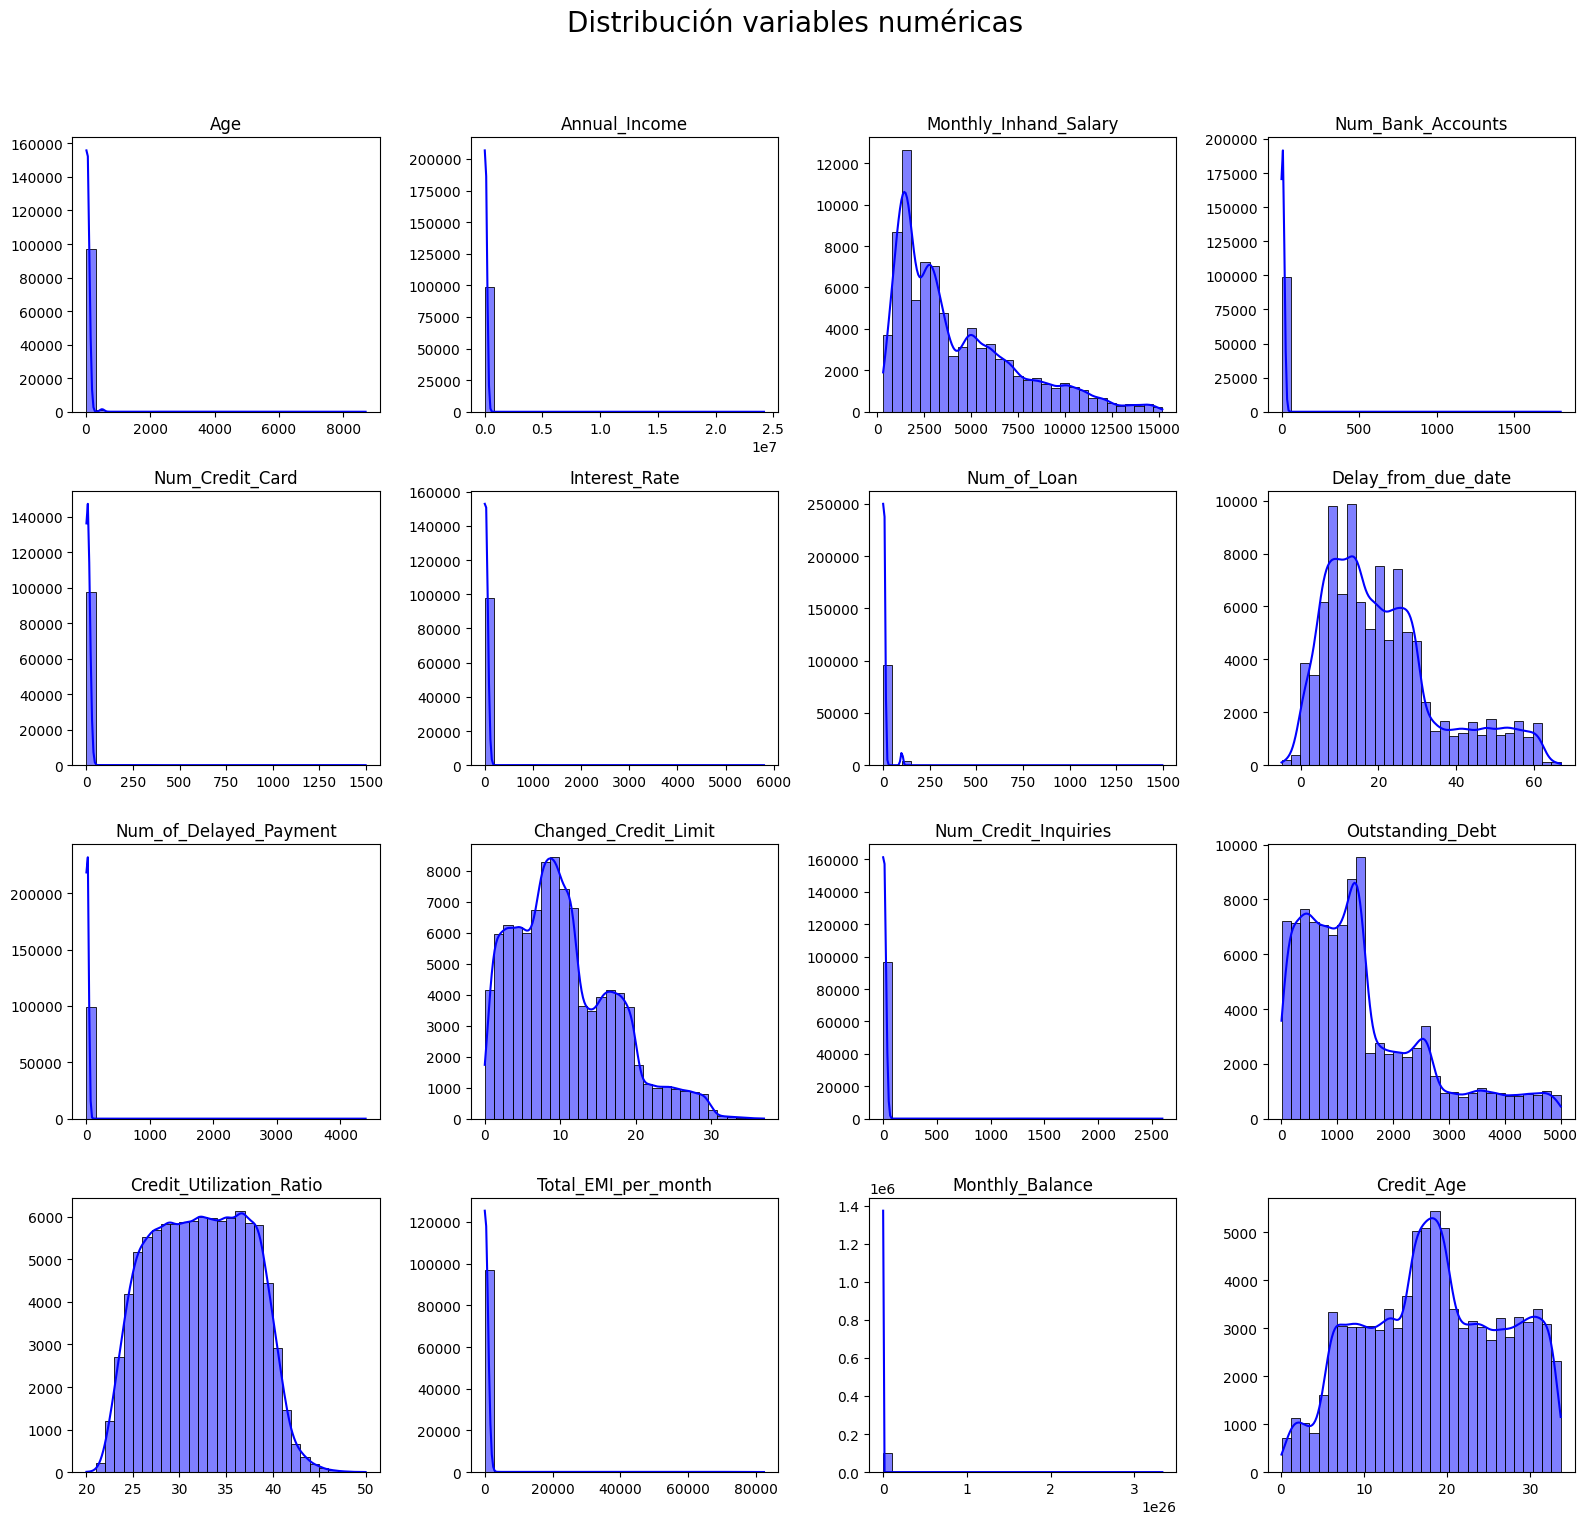

In [9]:
# Elegimos las columnas que sean numéricas
numeric_cols = [col for col in data.columns if data[col].dtype != 'object' and col != "CS"]


# Creamos una figura con subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Distribución variables numéricas', fontsize=20)

# Graficamos cada columna por medio de un ciclo
for i, column in enumerate(numeric_cols):
    row = i // 4
    col = i % 4
    sns.histplot(data[column], bins=30, kde=True, color='blue', ax=axes[row, col])
    axes[row, col].set_title(column)
    # Dejamos en blanco los labels de los subplots para apreciar mejor las gráficas
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Parece que en algunas columnas hay datos muy atípicos, que podrían tratarse de errores, por ejemplo:

* Annual Income
* Num bank accounts
* Num credit Card
* Interest Rate
* Num of Loan
* Num of delayed Payment
* Num Credit Inquiries
* Total EMI per Month

In [10]:
# Vemos datos estadísticos de las variables con dudas.
data[['Age','Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 
      'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Total_EMI_per_month', 'Monthly_Balance']]\
            .describe(percentiles=[0.25, 0.5, 0.75, 0.80, 0.85, 0.90, 0.95]).T.drop("count", axis=1)

,mean,std,min,25%,50%,75%,80%,85%,90%,95%,max
Age,1.195097e+02,6.847573e+02,14.00000,25.000000,34.000000,42.000000,44.000000,47.000000,50.000000,54.000000,8.698000e+03
Annual_Income,1.764157e+05,1.429618e+06,7005.93000,19457.500000,37578.610000,72790.920000,82334.016000,95332.230000,113085.870000,134533.320000,2.419806e+07
Num_Bank_Accounts,1.709128e+01,1.174048e+02,-1.00000,3.000000,6.000000,7.000000,8.000000,8.000000,9.000000,10.000000,1.798000e+03
Num_Credit_Card,2.247443e+01,1.290574e+02,0.00000,4.000000,5.000000,7.000000,7.000000,8.000000,9.000000,10.000000,1.499000e+03
Interest_Rate,7.246604e+01,4.664226e+02,1.00000,8.000000,13.000000,20.000000,23.000000,26.000000,29.000000,33.000000,5.797000e+03
Num_of_Loan,1.076196e+01,6.178993e+01,0.00000,2.000000,3.000000,6.000000,6.000000,7.000000,8.000000,9.000000,1.496000e+03
Num_of_Delayed_Payment,2.877941e+01,2.181148e+02,0.00000,8.000000,13.000000,18.000000,19.000000,20.000000,21.000000,23.000000,4.397000e+03
Num_Credit_Inquiries,2.775425e+01,1.931773e+02,0.00000,3.000000,6.000000,9.000000,10.000000,11.000000,12.000000,13.000000,2.597000e+03
Total_EMI_per_month,1.403118e+03,8.306041e+03,0.00000,30.306660,69.249473,161.224249,190.641975,228.382711,285.631602,437.012753,8.233100e+04
Monthly_Balance,3.036437e+22,3.181295e+24,0.00776,270.114473,336.742315,470.332133,524.095741,602.908248,708.104928,862.900078,3.333333e+26


Observando algunos datos estadísticos con mucha seguridad que hay errores en los datos, ya que hay brincos muy drásticos a partir del percentil 95, por lo que vamos a hacer una limpieza de sustituir estos datos por la mediana de cada columna (usamos la mediana debido a los datos atípicos, usar la media podría causar ruido).

In [11]:
# Limpiamos datos atípicos
def replace_outliers_with_median(series, perc):
    """
    Reemplaza los valores atípicos en una serie (columna de un DataFrame) con la mediana.
    Los valores atípicos se definen como aquellos que están por encima del percentil 90.

    Parameters:
    series (pd.Series): La columna del DataFrame a la que se aplicará la función.
    percentil (float): A partir de cual percentil sustituir valores.

    Returns:
    pd.Series: La columna con los valores atípicos reemplazados por la mediana.
    """
    # Calcula el percentil establecido
    p90 = series.quantile(perc)
    
    # Calcula la mediana
    median = series.median()
    
    # Reemplaza los valores mayores al percentil 90 por la mediana
    return series.apply(lambda x: median if x > p90 else x)

# Limpiamos las variables en bucle
for i in ['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 
      'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Total_EMI_per_month', 'Monthly_Balance']:
    data[i] = replace_outliers_with_median(data[i], perc=0.95)

# Limpiamos la columna credit mix
credit_mix_mapping = {
    'Bad': 1,
    'Standard': 2,
    'Good': 3,
    # Vamos a castigar con 0s a los que tengan dato nulo de credit mix
    np.nan: 0
}

# Reemplazar '_' con NaN antes de mapear
data['Credit_Mix'] = data['Credit_Mix'].replace('_', np.nan)

# Aplicar el mapeo
data['Credit_Mix_Numeric'] = data['Credit_Mix'].map(credit_mix_mapping)

# Age se sustituirá con la mediana a datos menores a 18 y mayores a 100
median_age = data["Age"].median()
data['Age'] = data['Age'].apply(lambda x: median_age if x < 18 or x > 100 else x)


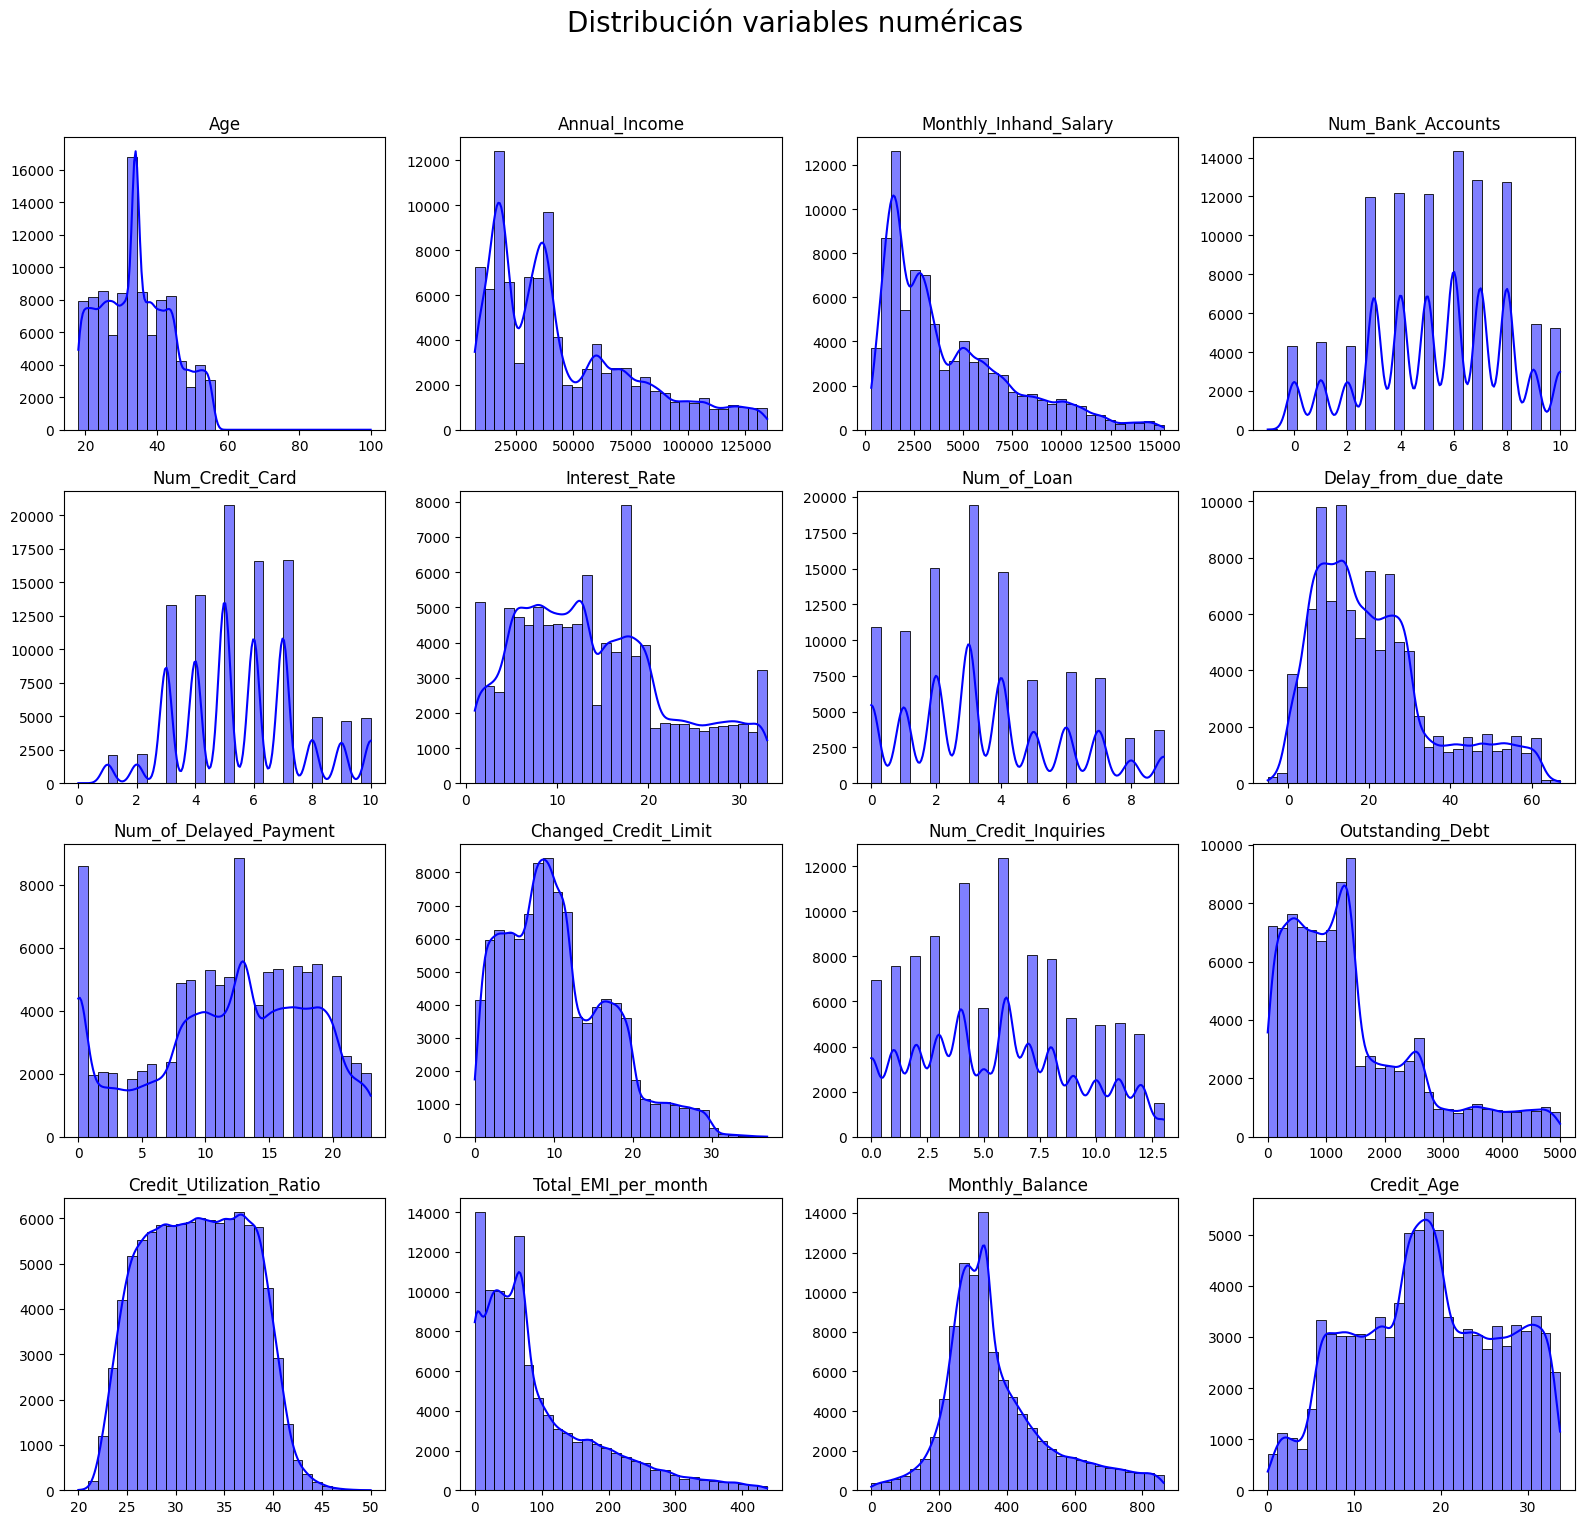

In [12]:
# Vemos las nuevas distribuciones
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Distribución variables numéricas', fontsize=20)

# Graficamos cada columna por medio de un ciclo
for i, column in enumerate(numeric_cols):
    row = i // 4
    col = i % 4
    sns.histplot(data[column], bins=30, kde=True, color='blue', ax=axes[row, col])
    axes[row, col].set_title(column)
    # Dejamos en blanco los labels de los subplots para apreciar mejor las gráficas
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Columnas que incuiremos directamente o indirectamente
* Outstanding_Debt
* Annual_Income
* Delay_from_due_date
* Num_of_Loan
* Num_Credit_Card
* Monthly_Inhand_Salary
* Num_Bank_Accounts
* Credit Mix
* Age
* Credit_Age
* Total_EMI_per_month

In [13]:
# Calculamos el ratio de deuda a ingreso. Este ratio mide la proporción de la deuda total en comparación con el ingreso anual.
data['Debt_to_Income_Ratio'] = data['Outstanding_Debt']/data['Annual_Income']

# Calculamos el promedio de retraso en los pagos. 
data['Avg_Delay_From_Due_Date'] = data.groupby('SSN')['Delay_from_due_date'].transform('mean')

# Calculamos el número total de créditos activos combinando el número de préstamos y el número de tarjetas de crédito.
data['Active_Credits'] = data['Num_of_Loan'] + data['Num_Credit_Card']

# Calculamos la estabilidad del ingreso. Este índice mide la proporción del salario mensual en comparación con el ingreso anual.
data['Income_Stability'] = data['Monthly_Inhand_Salary'] / (data['Annual_Income'] / 12)

# Calculamos el ratio de la edad del cliente y el tiempo teniendo crédito. Validamos divisiones entre 0
data['Credit_Age_to_Age_Ratio'] = np.where(data['Age'] == 0, 0, data['Credit_Age'] / data['Age'])

# Seleccionamos las variables que utilizaremos para el modelado
model = data[["ID", "Debt_to_Income_Ratio", "Avg_Delay_From_Due_Date", "Active_Credits", "Income_Stability", 
              "Num_Bank_Accounts", "Credit_Mix_Numeric", "Credit_Age_to_Age_Ratio", "Total_EMI_per_month"]]
# Rellenamos con 0s datos nulos
model.fillna(0, inplace=True)
model.describe(percentiles=[0.25, 0.5, 0.75, 0.80, 0.85, 0.90, 0.95]).T

,count,mean,std,min,25%,50%,75%,80%,85%,90%,95%,max
Debt_to_Income_Ratio,100000.0,0.060998,0.086712,0.000003,0.011063,0.029343,0.069571,0.088274,0.118505,0.164237,0.243775,0.683252
Avg_Delay_From_Due_Date,100000.0,21.068780,14.363328,-2.000000,10.375000,19.000000,27.375000,29.375000,34.714286,44.142857,53.625000,63.428571
Active_Credits,100000.0,9.029600,3.724194,0.000000,6.000000,8.000000,11.000000,12.000000,13.000000,15.000000,16.000000,19.000000
Income_Stability,100000.0,0.955655,0.700072,0.000000,0.902647,0.986962,1.038694,1.055472,1.081791,1.128449,1.253717,4.855305
Num_Bank_Accounts,100000.0,5.375490,2.577189,-1.000000,3.000000,6.000000,7.000000,8.000000,8.000000,9.000000,10.000000,10.000000
Credit_Mix_Numeric,100000.0,1.649580,1.057486,0.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000
Credit_Age_to_Age_Ratio,100000.0,0.521884,0.341539,0.000000,0.294118,0.489899,0.710145,0.777778,0.861111,0.968391,1.163043,1.870370
Total_EMI_per_month,100000.0,94.245915,89.605855,0.000000,30.306660,69.248079,133.355905,161.224249,190.645762,228.382711,285.637274,437.012753


Nos centramos en desarrollar el modelo en función de tres áreas clave que consideramos fundamentales:

1. **Riesgo Crediticio**. (60%)

* *Debt_to_Income_Ratio* (relación deuda/ingresos) - 40%
* *Avg_Delay_From_Due_Date* (retraso promedio en pagos) - 60%

Un valor más alto en cualquiera de estas variables indica un mayor riesgo crediticio, ya que sugiere que el cliente está más endeudado o tiene problemas para cumplir con sus obligaciones financieras a tiempo.

2. **Estabilidad Financiera**. (25%)

* *Income_Stability* (estabilidad de ingresos) - 42%
* *Active_Credits* (créditos activos) - 54%
* *Num_Bank_Accounts* (número de cuentas bancarias) - 0.04%

Estas variables nos permitirán evaluar si el cliente tiene un flujo de ingresos estable y una gestión equilibrada de sus productos financieros. Un cliente con mayor estabilidad en sus ingresos y una distribución adecuada de sus créditos y cuentas bancarias suele ser menos riesgoso.

3. **Experiencia Crediticia**. (15%)

* *Credit_Age_to_Age_Ratio* (relación entre antigüedad crediticia y edad) - 35%
* *Total_EMI_per_month* (solvencia fianciera) - 0.05
* *Credit_Mix_Numeric* (mezcla de tipos de crédito) - 60%

Un valor alto en las variables sugiere que el cliente tiene una experiencia más amplia en el manejo del crédito. Cuanto mayor sea la experiencia crediticia, mayor será la capacidad del cliente para gestionar sus obligaciones de manera eficaz.

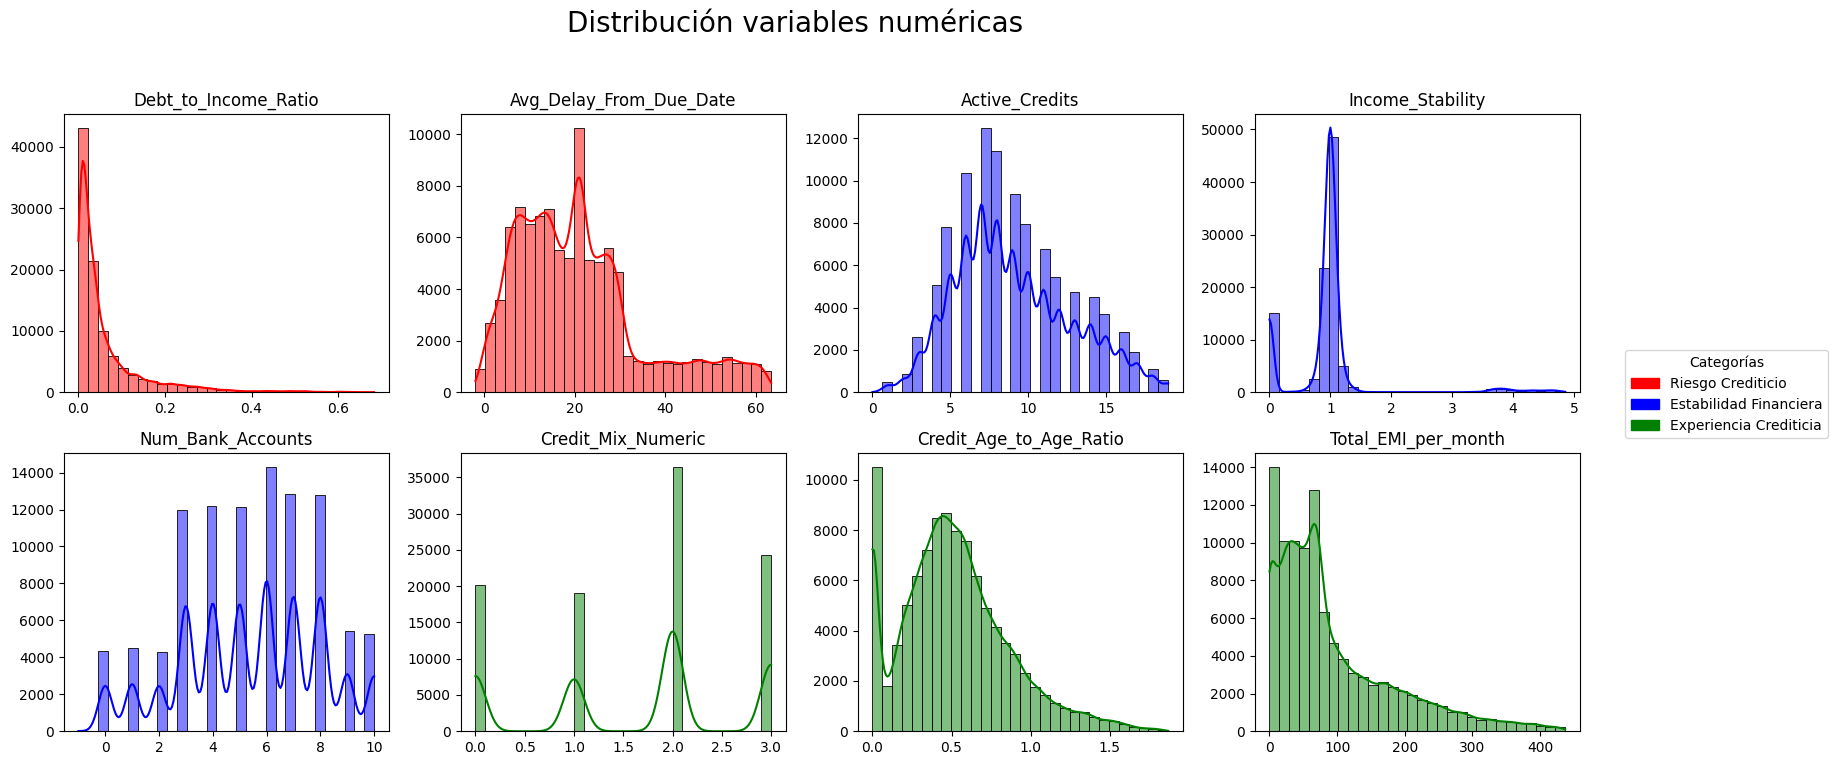

In [14]:
model_cols = [i for i in model.columns if i != "ID"]

# Vemos las nuevas distribuciones
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Distribución variables numéricas', fontsize=20)

# Les asignamos un color dependiendo de la categoría
color_subplots = {
    'Debt_to_Income_Ratio': 'red',
    'Credit_Utilization_Ratio': 'red',
    'Avg_Delay_From_Due_Date': 'red',    
    'Income_Stability': 'blue',          
    'Active_Credits': 'blue',            
    'Num_Bank_Accounts': 'blue',         
    'Credit_Mix_Numeric': 'green',       
    'Credit_Age_to_Age_Ratio': 'green',   
    'Total_EMI_per_month': 'green'
}


# Graficamos cada columna por medio de un ciclo
for i, column in enumerate(model_cols):
    row = i // 4
    col = i % 4
    sns.histplot(model[column], bins=30, kde=True, color=color_subplots[column], ax=axes[row, col])
    axes[row, col].set_title(column)
    # Dejamos en blanco los labels de los subplots para apreciar mejor las gráficas
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

# Añadimos la leyenda
handles = [patches.Patch(color=color, label=label) for label, color in {
    'Riesgo Crediticio': 'red',
    'Estabilidad Financiera': 'blue',
    'Experiencia Crediticia': 'green'
}.items()]

# Agregamos la leyenda a la figura
fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.15, 0.5), title='Categorías')

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Mientras mayores sean los ratios como el *Debt_to_Income_Ratio* y el *Avg_Delay_From_Due_Date*, mayor es el riesgo, lo cual debería reflejarse en una puntuación más baja y no más alta. Por tanto, si estos valores se están usando directamente en la ponderación final para calcular el puntaje de crédito, necesitamos invertir la lógica para que un mayor riesgo se traduzca en un menor puntaje y de una vez escalar los valores de 0 a 1.

En cuanto a las variables de Estabilidad financiera para los casos de *Active_Credits* y *Num_Bank_Accounts* creemos que no es bueno tener pocas ni demasiadas por lo que también se hará una transformacion MAD (Median Absolute Deviation). Esta técnica ajusta los valores en función de la mediana, normalizándolos a una escala de 0 a 1. De esta forma, se evita que valores extremadamente bajos o altos influyan negativamente en la evaluación de la estabilidad financiera, enfocándose en un rango óptimo que refleja mejor una salud financiera equilibrada.

Para las variables *Income_Stability*, *Credit_Mix*, *Total_EMI_per_month* y *Credit_Age_To_Age_Ratio*, consideramos que su distribución ya refleja adecuadamente la estabilidad financiera y la experiencia crediticia (Mientras mayor, mejor). Por lo tanto, simplemente escalaremos estos valores a una escala de 0 a 1. Esta transformación asegura que todas las variables estén en un rango uniforme, facilitando la combinación de diferentes métricas en el modelo sin alterar la interpretación de cada una.

In [15]:
# Invertir los ratios de riesgo y escalar de 0 a 1
model['Debt_to_Income_Ratio'] = 1 - ((model['Debt_to_Income_Ratio'] - model['Debt_to_Income_Ratio'].min()) / 
                                     (model['Debt_to_Income_Ratio'].max() - model['Debt_to_Income_Ratio'].min()))
model['Avg_Delay_From_Due_Date'] = 1 - ((model['Avg_Delay_From_Due_Date'] - model['Avg_Delay_From_Due_Date'].min()) / 
                                        (model['Avg_Delay_From_Due_Date'].max() - model['Avg_Delay_From_Due_Date'].min()))

# Mediana de las variables de estabilidad financiera
median_active_credits = model['Active_Credits'].median()
median_num_bank_accounts = model['Num_Bank_Accounts'].median()

# Transformación MAD con reescala de 0 a 1
model['Active_Credits'] = 1 - np.abs(model['Active_Credits'] - median_active_credits) / model['Active_Credits'].max()
model['Num_Bank_Accounts'] = 1 - np.abs(model['Num_Bank_Accounts'] - median_num_bank_accounts) / model['Num_Bank_Accounts'].max()

# Normalizar utilizando Min-Max Scaling
def min_max_scaling(column):
    """Función para escalar a rangos de 0 a 1

    Args:
        column (pd.series): Columna de un DataFrame con los datos que se quieran escalar

    Returns:
        column (pd.series): Columna de un DataFrame con los datos transformados.
    """
    return (model[column] - model[column].min()) / (model[column].max() - model[column].min())


# Escalamos el resto de columnas
for i in ["Income_Stability", "Credit_Mix_Numeric", "Credit_Age_to_Age_Ratio", 'Total_EMI_per_month']:
    model[i] = min_max_scaling(i)

Vemos nuevamente las distribuciones para ver los cambios y comprobar las nuevas tendencias.

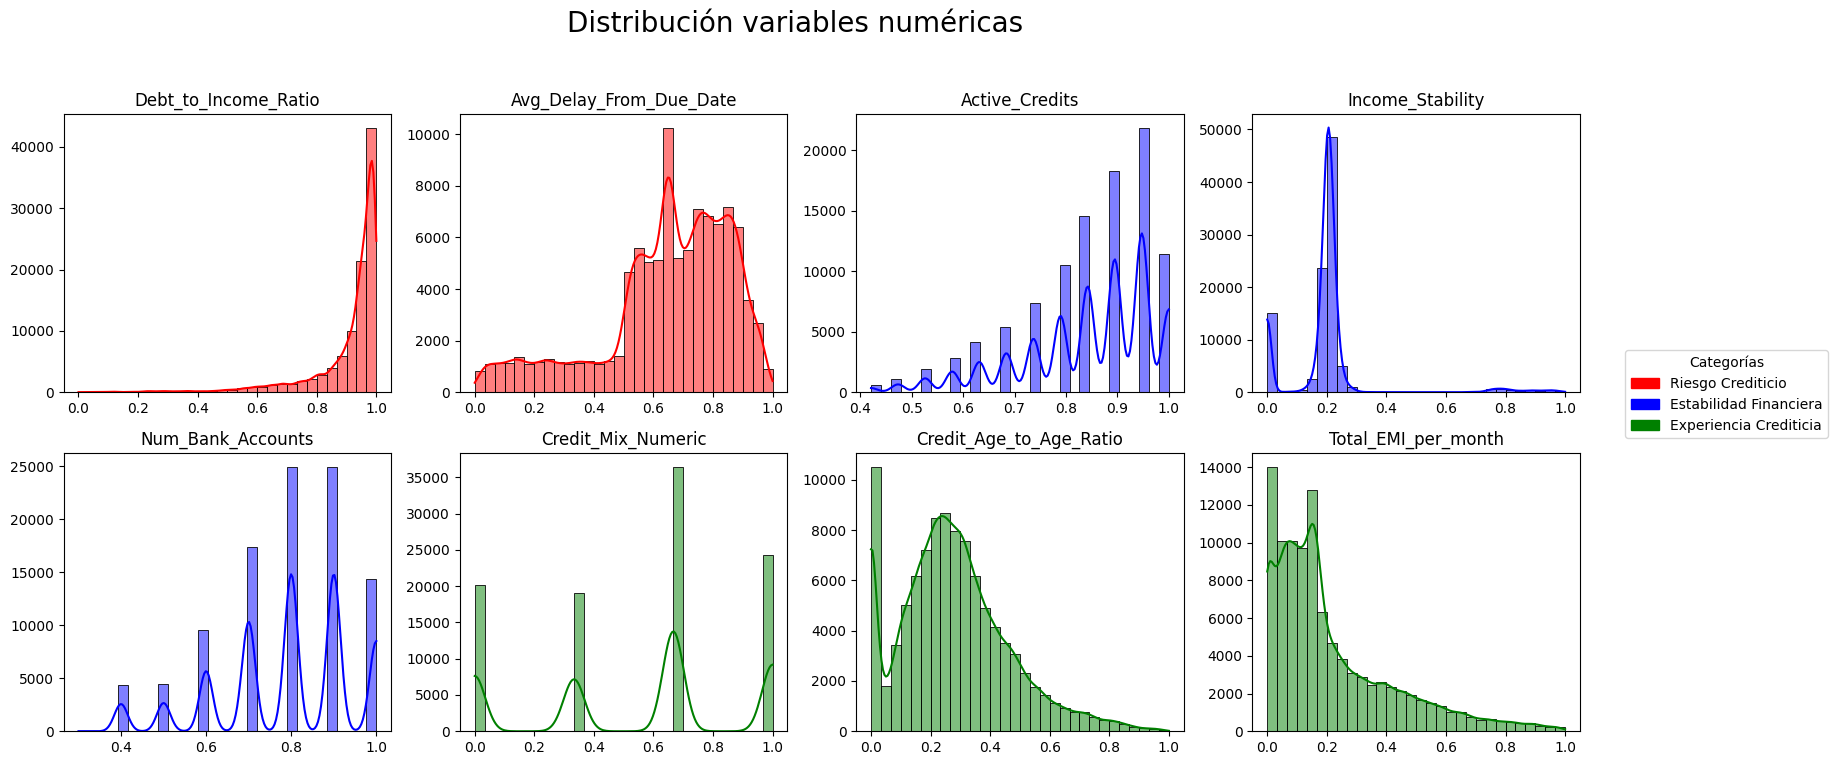

In [16]:
# Volvemos a graficar las distribuciones
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Distribución variables numéricas', fontsize=20)

# Graficamos cada columna por medio de un ciclo
for i, column in enumerate(model_cols):
    row = i // 4
    col = i % 4
    sns.histplot(model[column], bins=30, kde=True, color=color_subplots[column], ax=axes[row, col])
    axes[row, col].set_title(column)
    # Dejamos en blanco los labels de los subplots para apreciar mejor las gráficas
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

# Añadimos la leyenda
handles = [patches.Patch(color=color, label=label) for label, color in {
    'Riesgo Crediticio': 'red',
    'Estabilidad Financiera': 'blue',
    'Experiencia Crediticia': 'green'
}.items()]

# Agregamos la leyenda a la figura
fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.15, 0.5), title='Categorías')

# Ajustamos el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Las distribuciones de las variables están ahora adecuadamente ajustadas para reflejar sus características respectivas. Han sido escaladas a un rango de 0 a 1, ya que sus distribuciones reflejan adecuadamente el riesgo del cliente, la estabilidad financiera y la experiencia crediticia. Estas transformaciones garantizan que todas las variables estén en una escala uniforme, facilitando su integración en el modelo y permitiendo una ponderación precisa y significativa.

In [18]:
# Riesgo Crediticio (50%)
model['Risk_Score'] = (
    0.4 * model['Debt_to_Income_Ratio'] +
    0.6 * model['Avg_Delay_From_Due_Date']
)

# Estabilidad Financiera (20%)
model['Stability_Score'] = (
    0.54 * model['Active_Credits'] +
    0.42 * model['Income_Stability'] +
    0.04 * model['Num_Bank_Accounts']
)

# Experiencia Crediticia (30%)
model['Experience_Score'] = (
    0.6 * model['Credit_Mix_Numeric'] +
    0.35 * model['Credit_Age_to_Age_Ratio'] + 
    0.05 * model['Total_EMI_per_month']
)

# Puntuación final del modelo
model['Credit_Score'] = (
    0.6 * model['Risk_Score'] +
    0.25 * model['Stability_Score'] +
    0.15 * model['Experience_Score']
)


# Escalar la puntuación final a una escala de 300 a 850
model['Credit_Score_850'] = 300 + (model['Credit_Score'] - model['Credit_Score'].min()) * (850 - 300) / (model['Credit_Score'].max() - model['Credit_Score'].min())

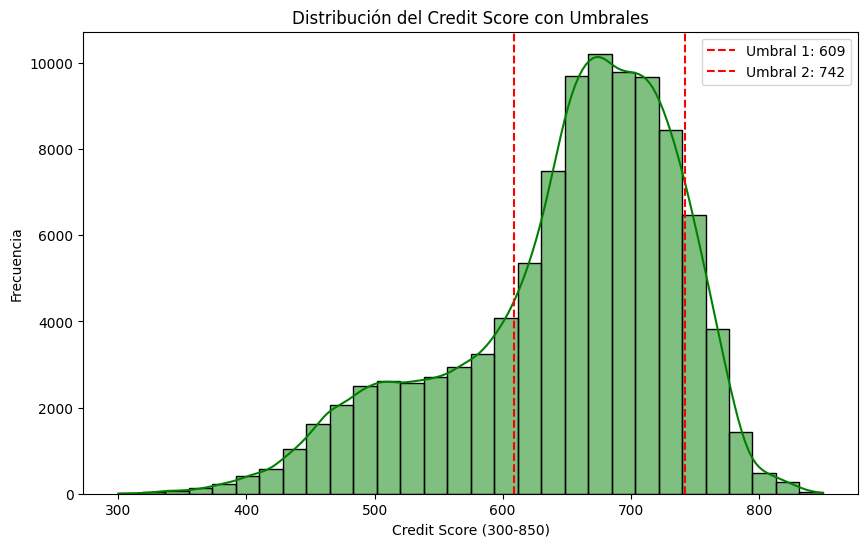

In [19]:
# Creamos un nuevo df solo con el ID y nuestra predicción
df_final = model[["ID", "Credit_Score_850"]]
# Agregamos el Credit Score Real
df_final = df_final.merge(data[["ID", "Credit_Score"]], on="ID")
# Creamos los umbrales con ayuda de la gráfica
threshold_1, threshold_2 = 609, 742

# Crear la gráfica de distribución
plt.figure(figsize=(10, 6))
sns.histplot(model['Credit_Score_850'], bins=30, kde=True, color="green")

# Agregar líneas verticales para los umbrales
plt.axvline(threshold_1, color='red', linestyle='--', label=f'Umbral 1: {threshold_1}')
plt.axvline(threshold_2, color='red', linestyle='--', label=f'Umbral 2: {threshold_2}')

# Etiquetas y título
plt.title("Distribución del Credit Score con Umbrales")
plt.xlabel("Credit Score (300-850)")
plt.ylabel("Frecuencia")
# Agregar leyenda para las líneas de umbral
plt.legend()

# Mostrar la gráfica
plt.show()

Accuracy Score: 59.10%


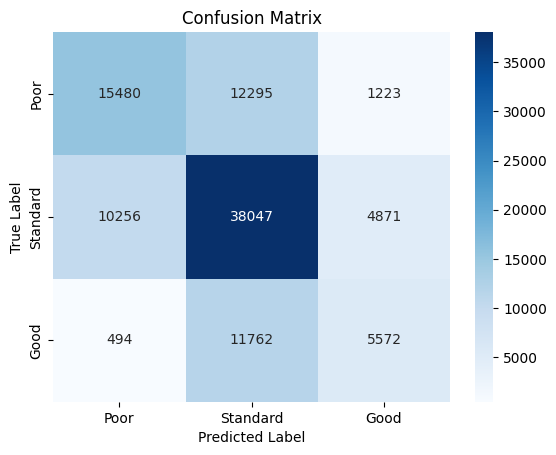

In [20]:
# Función para asignar las etiquetas basadas en los umbrales
def assign_label(score):
    """Función para asignar la etiqueta (Poor, Standard, Good) dependiendo de su score y los umbrales

    Args:
        score (float): Score conseguido con nuestra métrica

    Returns:
        str: Etiqueta del ID
    """
    if score < threshold_1:
        return 'Poor'
    elif score < threshold_2:
        return 'Standard'
    else:
        return 'Good'

# Aplicar la función a la columna 'Credit_Score_1000' para generar las predicciones
df_final['Predicted_Label'] = df_final['Credit_Score_850'].apply(assign_label)
# Sacamos las etiquetas
y_true = df_final['Credit_Score']
y_pred = df_final['Predicted_Label']
# Generamos una métrica para ver a cuantos si los etiquetamos correctamente.
accuracy = (df_final['Credit_Score'] == df_final['Predicted_Label']).mean()


# Mostrar el resultado
print(f"Accuracy Score: {accuracy * 100:.2f}%")

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=['Poor', 'Standard', 'Good'])
# Crear un heatmap con seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])

# Etiquetas y título
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Reporte de clasificación con precisión, recall y F1-score
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

        Good       0.48      0.31      0.38     17828
        Poor       0.59      0.53      0.56     28998
    Standard       0.61      0.72      0.66     53174

    accuracy                           0.59    100000
   macro avg       0.56      0.52      0.53    100000
weighted avg       0.58      0.59      0.58    100000

